# SVM and GDA for CIFAR-10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC, SVC

from scipy.spatial.distance import cdist

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# The CIFAR10 dataset
- Download and normalize the CIFAR10 dataset from torchvision
- Split the CIFAR10 data into train, validation and test set
- Set the batch size for processing these datasets
- Build the dataloaders for train, validation, and test set which will be used in the training loop
- Define the string class labels (targets are numeric 0-9)

In [3]:
# mean and std for the RGB channels in CIFAR10
tmean = [0.49139968, 0.48215841, 0.44653091]
tstd = [0.24703223, 0.24348513, 0.26158784]

# transform the 32x32x3 images into a tensor after normalizing
# each channel using the parameters above
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(tmean, tstd)])

# download and transform the  trainset and testset for training
trainset = torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)

#split trainset into a train and a val set (90-10 split)
lengths = [int(p * len(trainset)) for p in [0.9,0.1]]
tr,v = torch.utils.data.random_split(trainset,lengths)
train_sampler = torch.utils.data.SubsetRandomSampler(tr.indices)
val_sampler = torch.utils.data.SubsetRandomSampler(v.indices)

# set batch size and set up the data generators for train, val, test sets
batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,sampler=train_sampler)
valloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,sampler=val_sampler)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

print("Number of training batches = ",len(trainloader))
print("Number of validation batches = ",len(valloader))
print("Number of test batches = ",len(testloader))

# define the output classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:11<00:00, 14632713.51it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Number of training batches =  352
Number of validation batches =  40
Number of test batches =  79


# Visualize the training data

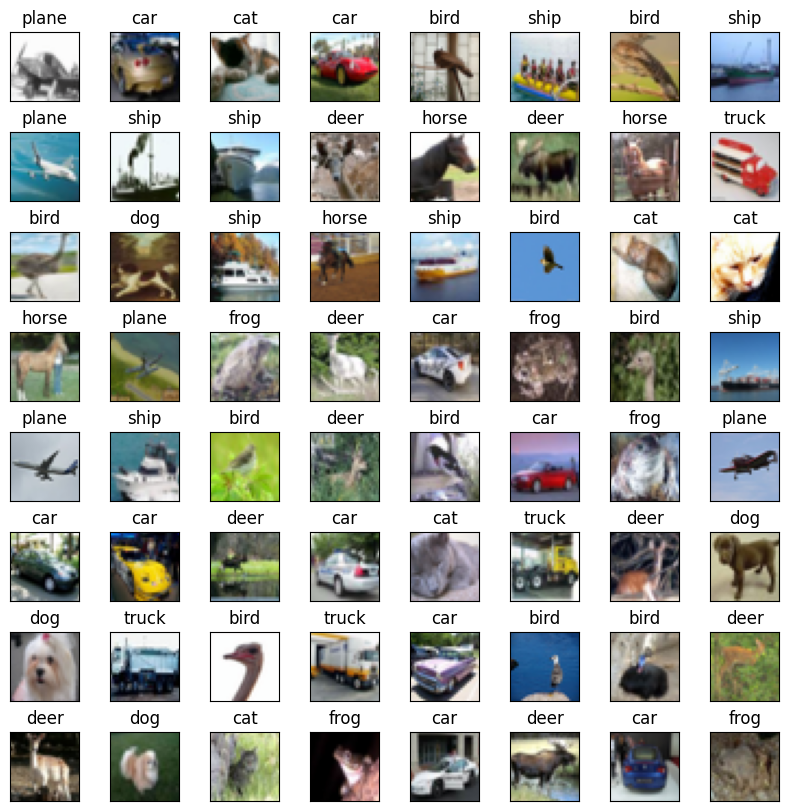

In [4]:
Xtr,ytr = next(iter(trainloader))
# make a 8x8 grid and display 64 images from the first batch of training data
rows,cols = 8,8
fig = plt.figure(figsize=(8,8),constrained_layout=True)

for i in range(0,rows*cols):
    fig.add_subplot(rows,cols,i+1)
    tmp = np.transpose(Xtr[i].numpy(),(1,2,0))
    plt.imshow(((tmp*tstd + tmean)*255).astype(np.uint8))
    plt.xticks([])
    plt.yticks([])
    plt.title(classes[ytr[i].numpy()])

# Accumulate the training, validation, and test sets

In [5]:
def extract_data(generator):
    X = torch.zeros((0,3,32,32))
    y = torch.zeros((0,))
    for (Xtr,ytr) in generator:
        X = torch.vstack([X,Xtr])
        y = torch.concat((y,ytr),axis=0)
    return X,y

Xtrain,ytrain = extract_data(trainloader)
print("Training data: ",Xtrain.shape,ytrain.shape)
Xval,yval = extract_data(valloader)
print("Validation data: ",Xval.shape,yval.shape)
Xtest,ytest = extract_data(testloader)
print("Test data: ",Xtest.shape,ytest.shape)

Training data:  torch.Size([45000, 3, 32, 32]) torch.Size([45000])
Validation data:  torch.Size([5000, 3, 32, 32]) torch.Size([5000])
Test data:  torch.Size([10000, 3, 32, 32]) torch.Size([10000])


# GDA with same covariance for each class (5 points)

Set up an LDA model using sklearn's [LDA](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) function (10 points)
    
- set up the LinearDiscriminantAnalysis classifier with 'lsqr' solver and store_covariance=True.
- fit this classifier on the training images (flattened into 50000 x 3072) and labels (50000).
- evaluate the trained model with the set aside test set using built in functions from sklearn.metrics: accuracy, confusion matrix, classification report (f1 scores). Remember to flatten the test images before running the .predict() function.
- visualize the means of the 10 classes, and interpret the images in relation to the classes they represent.

In [6]:
# concatenate the train and validation sets for GDA
trainX = torch.vstack((Xtrain,Xval))
trainy = torch.cat([ytrain,yval])
print(trainX.shape,trainy.shape)

torch.Size([50000, 3, 32, 32]) torch.Size([50000])


In [7]:
# your code here (LDA model with same covariance for every class)

# remember to reshape trainX as (50000,3072)
# set up LDA model and fit on (trainX,trainy)
# about 2 lines
lda = LinearDiscriminantAnalysis(solver="lsqr", store_covariance=True) # Least squares solver
lda.fit(trainX.reshape([trainX.shape[0], -1]), trainy)


LinearDiscriminantAnalysis(solver='lsqr', store_covariance=True)

In [8]:
torch.save(lda, '/content/drive/MyDrive/COMP540_Asst3/lda_model.pth')

In [9]:
lda = torch.load('/content/drive/MyDrive/COMP540_Asst3/lda_model.pth')

# Test model on Xtest and ytest (4 points)
- print accuracy of model on (Xtest,ytest)
- print classification report
- print confusion_matrix

In [10]:
#your code here (remember to reshape Xtest)
# about 4 lines
yhattest = lda.predict(Xtest.reshape([Xtest.shape[0], -1]))

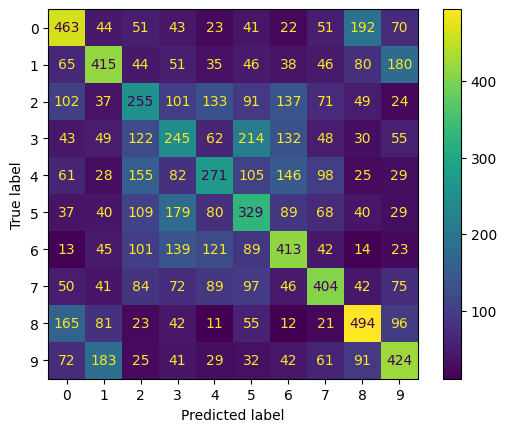


 Accuracy:  37.13 %

 Classification Report: 
               precision    recall  f1-score   support

         0.0       0.43      0.46      0.45      1000
         1.0       0.43      0.41      0.42      1000
         2.0       0.26      0.26      0.26      1000
         3.0       0.25      0.24      0.25      1000
         4.0       0.32      0.27      0.29      1000
         5.0       0.30      0.33      0.31      1000
         6.0       0.38      0.41      0.40      1000
         7.0       0.44      0.40      0.42      1000
         8.0       0.47      0.49      0.48      1000
         9.0       0.42      0.42      0.42      1000

    accuracy                           0.37     10000
   macro avg       0.37      0.37      0.37     10000
weighted avg       0.37      0.37      0.37     10000



In [11]:
accuracy = accuracy_score(ytest, yhattest)
class_report = classification_report(ytest, yhattest)
confusion_mat = confusion_matrix(ytest, yhattest)

cm_disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_mat)
cm_disp.plot()
plt.show()

print("\n Accuracy: ", accuracy*100, "%")
print("\n Classification Report: \n", class_report)

# Visualize the means (1 point)
- comment on the visualizations in this cell. That is, interpret these means in terms of the classes they represent.

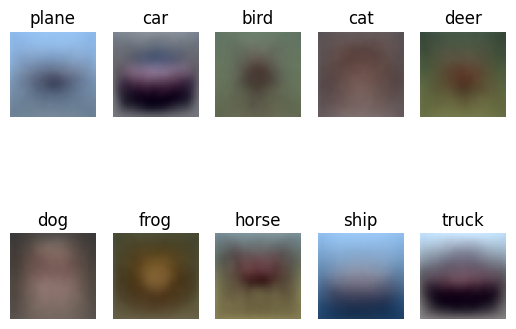

In [12]:
# Run this cell; no code to write.

mean = lda.means_.reshape(10, 32, 32, 3) # 10 x 32 x 32 x 3
class_min, class_max = np.min(lda.means_), np.max(lda.means_)

for i in range(10):
    plt.subplot(2, 5, i + 1)
    tmp = np.transpose(lda.means_[i].reshape((3,32,32)),(1,2,0))
    tmp = (255.0 * (tmp - class_min) / (class_max - class_min)).astype('uint8')
    plt.imshow(tmp)
    plt.axis('off')
    plt.title(classes[i])

plt.show()

## Interpretation of the means:

The means capture the general colour patterns and locations of objects present in the images.

# Run SVM on CIFAR10 (40 points)

The sklearn implementation of SVM (SVC) is very slow, because it uses all points in the training set as landmarks. So to speed up the process, we will only use a subset of 5000 images for training.

- build a linear kernel SVC model with probability = False and regularization constant C drawn from a set of values C_vals. For each C, train a linear kernel SVM on the 5000 image training set (sXtrain,sytrain) and measure accuracy on the validation set (Xval,yval). Plot C value vs val set accuracy on a semi-log plot. What is the best value of C for this training set? Build a linear model with that value of C and report accuracy, classification report, and confusion matrix on the full test set.
- build an RBF kernel SVC model with probability = False and regularization constant C drawn from a set of values C_vals. For each C, train an RBF kernel SVM on the 5000 image training set (sXtrain,sytrain) and measure accuracy on the validation set (Xval,yval). Plot C value vs val set accuracy on a semi-log plot. What is the best value of C for this training set? Build an RBF model with that value of C and report accuracy, classification report, and confusion matrix on the full test set.
- Comment on performance differences between the two models, if any.

In [13]:
# subselect 5000 examples from the CIFAR-10 dataset
N = 5000
sXtrain = trainX[:N]
sytrain = trainy[:N]

# Linear SVM kernel
- choosing regularization C using a validation set

In [18]:
C_vals = np.array([0.0001,0.001,0.01,0.1,1,10])

# your code here for fitting and selecting C (about 6 lines)
val_accuracies = []
for C_val in C_vals:
  linSVC = SVC(probability=False, C=C_val, kernel='linear', random_state=9)
  linSVC.fit(sXtrain.reshape(sXtrain.shape[0], -1), sytrain)
  yhatval = linSVC.predict(Xval.reshape([Xval.shape[0], -1]))
  val_accuracies.append(accuracy_score(yval, yhatval))

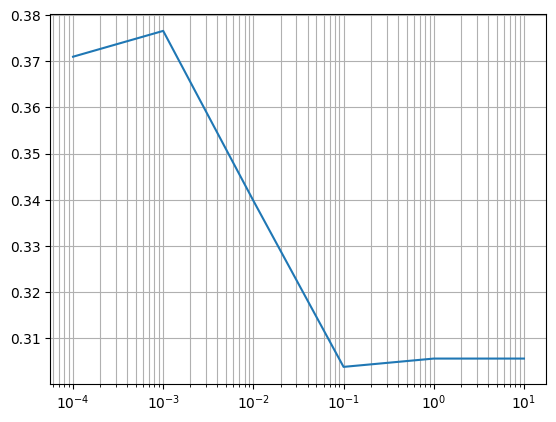

In [19]:
# plot C_vals and val set accuracy in a semilog plot
# 1 line of code
# your code here
plt.grid(True, which ="both")
plt.semilogx(C_vals, val_accuracies)
plt.show()

In [20]:
# build model with best value of C
# print test accuracy, confusion matrix and classification report on test set
# about 5 lines of code
C_best = C_vals[val_accuracies.index(max(val_accuracies))]
print("Best C_val is", str(C_best))

Best C_val is 0.001


In [22]:
linSVM = LinearSVC(C=C_best, verbose=1, dual=False, random_state=9)
linSVM.fit(trainX.reshape([trainX.shape[0], -1]), trainy)

[LibLinear]

LinearSVC(C=0.001, dual=False, random_state=9, verbose=1)

In [23]:
torch.save(linSVM, '/content/drive/MyDrive/COMP540_Asst3/linSVM_model.pth')

In [ ]:
linSVM = torch.load('/content/drive/MyDrive/COMP540_Asst3/linSVM_model.pth')

In [24]:
yhattest = linSVM.predict(Xtest.reshape([Xtest.shape[0], -1]))

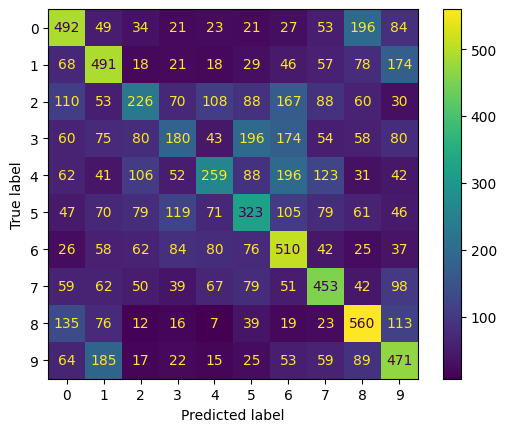


 Accuracy:  39.65 %

 Classification Report: 
               precision    recall  f1-score   support

         0.0       0.44      0.49      0.46      1000
         1.0       0.42      0.49      0.45      1000
         2.0       0.33      0.23      0.27      1000
         3.0       0.29      0.18      0.22      1000
         4.0       0.37      0.26      0.31      1000
         5.0       0.34      0.32      0.33      1000
         6.0       0.38      0.51      0.43      1000
         7.0       0.44      0.45      0.45      1000
         8.0       0.47      0.56      0.51      1000
         9.0       0.40      0.47      0.43      1000

    accuracy                           0.40     10000
   macro avg       0.39      0.40      0.39     10000
weighted avg       0.39      0.40      0.39     10000



In [25]:
accuracy = accuracy_score(ytest, yhattest)
class_report = classification_report(ytest, yhattest)
confusion_mat = confusion_matrix(ytest, yhattest)

cm_disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_mat)
cm_disp.plot()
plt.show()

print("\n Accuracy: ", accuracy*100, "%")
print("\n Classification Report: \n", class_report)

# RBF SVM kernel
- choosing regularization C using a validation set

In [27]:
C_vals = np.array([0.0001,0.001,0.01,0.1,1,10,100])

# your code here for finding good value of C for RBF kernel
# about 6 lines
val_accuracies = []
for C_val in C_vals:
  rbfSVC = SVC(probability=False, C=C_val, verbose=True, kernel='rbf', random_state=9)
  rbfSVC.fit(sXtrain.reshape(sXtrain.shape[0], -1), sytrain)
  yhatval = rbfSVC.predict(Xval.reshape([Xval.shape[0], -1]))
  val_accuracies.append(accuracy_score(yval, yhatval))

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

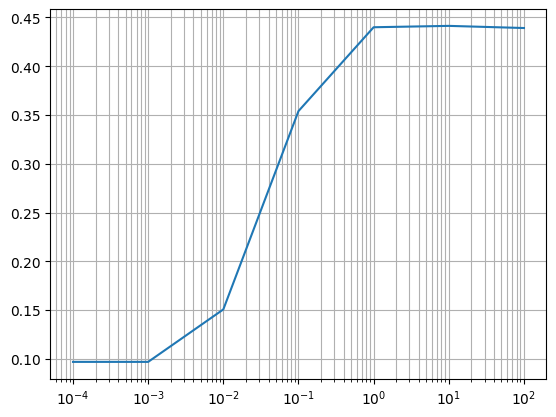

In [28]:
# plot C_vals and val set accuracy in a semilog plot
# 1 line of code
# your code here
plt.grid(True, which ="both")
plt.semilogx(C_vals, val_accuracies)
plt.show()

In [29]:
# build model with best value of C
# print test accuracy, confusion matrix and classification report on test set
# about 5 lines of code
C_best = C_vals[val_accuracies.index(max(val_accuracies))]
print("Best C_val is", str(C_best))

Best C_val is 10.0


In [30]:
rbfSVM = SVC(C=C_best, verbose=True, kernel='rbf', random_state=9, probability=False)
rbfSVM.fit(trainX.reshape([trainX.shape[0], -1]), trainy)

[LibSVM]

SVC(C=10.0, random_state=9, verbose=True)

In [31]:
torch.save(rbfSVM, '/content/drive/MyDrive/COMP540_Asst3/rbfSVM_model.pth')

In [ ]:
rbfSVM = torch.load('/content/drive/MyDrive/COMP540_Asst3/rbfSVM_model.pth')

In [32]:
yhattest = rbfSVM.predict(Xtest.reshape([Xtest.shape[0], -1]))

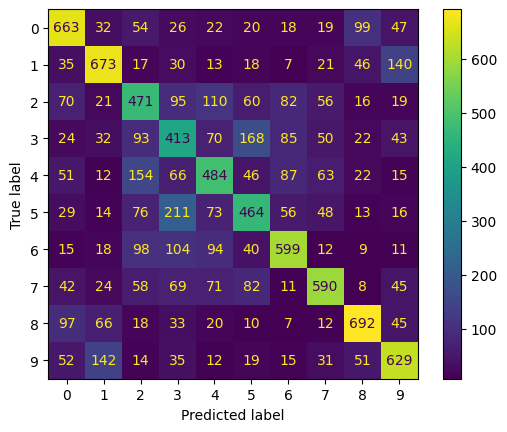


 Accuracy:  56.779999999999994 %

 Classification Report: 
               precision    recall  f1-score   support

         0.0       0.62      0.66      0.64      1000
         1.0       0.65      0.67      0.66      1000
         2.0       0.45      0.47      0.46      1000
         3.0       0.38      0.41      0.40      1000
         4.0       0.50      0.48      0.49      1000
         5.0       0.50      0.46      0.48      1000
         6.0       0.62      0.60      0.61      1000
         7.0       0.65      0.59      0.62      1000
         8.0       0.71      0.69      0.70      1000
         9.0       0.62      0.63      0.63      1000

    accuracy                           0.57     10000
   macro avg       0.57      0.57      0.57     10000
weighted avg       0.57      0.57      0.57     10000



In [33]:
# your code here
# build best RBF model with best value of C
# report test set accuracy, confusion matrix and classification report on test set
# about 6 lines of code
accuracy = accuracy_score(ytest, yhattest)
class_report = classification_report(ytest, yhattest)
confusion_mat = confusion_matrix(ytest, yhattest)

cm_disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_mat)
cm_disp.plot()
plt.show()

print("\n Accuracy: ", accuracy*100, "%")
print("\n Classification Report: \n", class_report)


# Comment on linear SVM vs RBF kernel SVM
- RBF is much more accurate than Linear SVM in this case.
- RBF training and prediction steps were slower in comparison with Linear